<a href="https://colab.research.google.com/github/KenzaxTazi/Agri-Risk/blob/master/Model_exploration_Raghul_for_Marc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tqdm==4.42.1


In [0]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o



Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 126.2MB 88kB/s 
  Created wheel for h2o: filename=h2o-3.28.0.3-py2.py3-none-any.whl size=126303006 sha256=35d513faf4d2fad965b412b30104fa7fb3d3a5d261c18eaa01b1923aa5c21590
  Stored in directory: /root/.cache/pip/wheels/fa/7c/ce/95ae52b4d3f1b14a27c3c961c1f94635aee841ab1eec3aeeca
Successfully built h2o


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import xarray as xr
import numpy as np


In [0]:
import os, sys

path = '/content/drive/My Drive/Team Plants/data'
os.chdir(path)

# Import full dataset # 

Here, we import the below dataset

In [0]:
dataset = pd.read_csv("head_of_soils_recommendations_MGM.csv")

In [0]:
dataset

,Unnamed: 0,Unnamed: 0.1,alloc_key,x,y,iso3,maize_a_2010,maize_a_2005,nearest_lat,nearest_lon,CDD-Q1-2010,CDD-Q2-2010,CDD-Q3-2010,CDD-Q4-2010,CDD-Q1-2005,CDD-Q2-2005,CDD-Q3-2005,CDD-Q4-2005,CFD-Q1-2010,CFD-Q2-2010,CFD-Q3-2010,CFD-Q4-2010,CFD-Q1-2005,CFD-Q2-2005,CFD-Q3-2005,CFD-Q4-2005,CWD-Q1-2010,CWD-Q2-2010,CWD-Q3-2010,CWD-Q4-2010,CWD-Q1-2005,CWD-Q2-2005,CWD-Q3-2005,CWD-Q4-2005,WW-Q1-2010,WW-Q2-2010,WW-Q3-2010,WW-Q4-2010,WW-Q1-2005,WW-Q2-2005,...,FD-04-05-2010,FD-04-05-2005,FD-05-05-2010,FD-05-05-2005,FD-06-05-2010,FD-06-05-2005,FD-07-05-2010,FD-07-05-2005,FD-08-05-2010,FD-08-05-2005,FD-09-05-2010,FD-09-05-2005,FD-10-05-2010,FD-10-05-2005,FD-11-05-2010,FD-11-05-2005,FD-12-05-2010,FD-12-05-2005,FD-01-15-2010,FD-01-15-2005,FD-02-15-2010,FD-02-15-2005,FD-03-15-2010,FD-03-15-2005,FD-04-15-2010,FD-04-15-2005,FD-05-15-2010,FD-05-15-2005,FD-06-15-2010,FD-06-15-2005,FD-07-15-2010,FD-07-15-2005,FD-08-15-2010,FD-08-15-2005,FD-09-15-2010,FD-09-15-2005,FD-10-15-2010,FD-10-15-2005,soil_types,climate_zones
0,0,0,4383640,123.291667,53.541667,CHN,3918.1,2819.2,53.75,123.25,27.0,29.0,9.0,17.0,57.0,33.0,14.0,36.0,90.0,61.0,0.0,65.0,90.0,65.0,1.0,64.0,3.0,5.0,6.0,4.0,2.0,3.0,7.0,5.0,3.0,0.0,1.0,2.0,0.0,0.0,...,10.0,10.0,7.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,10.0,10.0,40,9
1,1,3,4393629,122.375000,53.458333,CHN,3119.3,2028.5,53.25,122.25,27.0,22.0,9.0,17.0,34.0,49.0,10.0,13.0,90.0,61.0,1.0,65.0,90.0,65.0,1.0,64.0,3.0,5.0,4.0,4.0,1.0,2.0,8.0,3.0,2.0,0.0,2.0,1.0,0.0,0.0,...,10.0,10.0,6.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,10.0,10.0,40,9
2,2,8,4403648,123.958333,53.375000,CHN,3230.1,2337.9,53.25,123.75,27.0,22.0,9.0,16.0,48.0,49.0,11.0,11.0,90.0,61.0,1.0,65.0,90.0,65.0,2.0,61.0,3.0,5.0,4.0,3.0,2.0,3.0,5.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,10.0,10.0,8.0,7.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,10.0,10.0,40,6
3,3,9,4403649,124.041667,53.375000,CHN,3119.3,2010.2,53.25,124.25,20.0,22.0,9.0,17.0,48.0,49.0,11.0,37.0,90.0,61.0,0.0,65.0,90.0,65.0,1.0,61.0,3.0,5.0,4.0,3.0,2.0,3.0,5.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,...,10.0,10.0,8.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,10.0,10.0,40,6
4,4,10,4413637,123.041667,53.291667,CHN,3918.1,2819.2,53.25,123.25,27.0,29.0,9.0,16.0,27.0,49.0,8.0,14.0,90.0,61.0,1.0,73.0,90.0,65.0,1.0,61.0,3.0,5.0,4.0,4.0,2.0,2.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,...,10.0,10.0,8.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,10.0,10.0,40,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427053,427053,832697,7660984,-98.041667,26.208333,USA,6148.3,6278.7,26.25,-97.25,16.0,23.0,33.0,16.0,12.0,48.0,24.0,19.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,11.0,13.0,10.0,3.0,2.0,6.0,7.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,-997
427054,427054,832720,7670981,-98.291667,26.125000,USA,5713.1,5832.9,26.25,-97.25,16.0,23.0,33.0,16.0,12.0,48.0,24.0,19.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,11.0,13.0,10.0,3.0,2.0,6.0,7.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,-997
427055,427055,832721,

In [0]:
data = dataset.copy()


## Data processing ## 

We now use Ed's script to process the data somewhat. Here we exclude the 10 day features.

In [0]:
# Create a custom data set adding in the features you want. It reads an already computed 
# dataset but you can then remove features to see the effect on score.
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import random

random_seed = 42
#random.seed(a=random_seed)
#np.random_seed(random_seed)



target = 'maize_a_2010'

X = data.drop(target,axis=1)


y = data[[target]]
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, y, test_size=0.2, random_state=random_seed)
del X
del y
del data

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#dataset.dropna(inplace=True)

### Create train test split ### 

### One-hot encode categorical features ###


In [0]:
categorical_variables = ["climate_zones",
                         "soil_types"
                       
                         ]

In [0]:
categories=[]

for i in categorical_variables:
  a = list(dataset[i].unique())
  categories.append(a)


In [0]:
df_num = train_set_x.copy()

for i in categorical_variables:
  df_num.drop(i, axis=1, inplace=True)

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([
                        ("selector", OneHotEncoder(), [0,1])], 
                        remainder = 'passthrough')

#0 and 1 refer to the categorical column names - these need to be changed so they are selected automatically and not manually as done here

In [0]:
train_set_x_prepared = ct.fit_transform(train_set_x)


In [0]:
train_set_x_prepared.shape

(243624, 154)

In [0]:
test_set_x_prepared = ct.transform(test_set_x)


# Model exploration # 

## Which models can at least fit the training data? ##

### Random Forests ###


For this example we can run without doing the feature selection above.

In [0]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=15, n_jobs=-1)
rnd_reg.fit(train_set_x_prepared,train_set_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Can we overfit to the training set? Does the model have enough sophisitication to overfit to the trainin set...

In [0]:
rnd_reg.score(train_set_x_prepared,train_set_y)

0.9945966246464768

In [0]:
rnd_reg.score(test_set_x_prepared,test_set_y)

0.9686268838624702

It could overfit if I train with enough max leaf nodes.




#### H2o implementation ####

In [0]:
h2o.shutdown()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_bc7e closed.


In [0]:
import h2o
h2o.init(nthreads=-1)
#h2o.init(nthreads = -1, max_mem_size = 12)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmzbs916r
  JVM stdout: /tmp/tmpmzbs916r/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmzbs916r/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,"28 days, 17 hours and 51 minutes"
H2O cluster name:,H2O_from_python_unknownUser_h98mt9
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
train = pd.DataFrame(train_set_x).join(train_set_y)
train = h2o.H2OFrame(train)


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
test = pd.DataFrame(test_set_x).join(test_set_y)
test = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:

x = train.col_names[:-1]    
y = train.col_names[-1]  

In [0]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1, categorical_encoding='enum', max_depth=200)
rf_fit1.train(x=x, y=y, training_frame=train, validation_frame=test)


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
rf_fit1.actual_params

{'balance_classes': False,
 'binomial_double_trees': False,
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'Enum',
 'check_constant_response': True,
 'checkpoint': None,
 'class_sampling_factors': None,
 'col_sample_rate_change_per_level': 1.0,
 'col_sample_rate_per_tree': 1.0,
 'custom_metric_func': None,
 'distribution': 'gaussian',
 'export_checkpoints_dir': None,
 'fold_assignment': 'AUTO',
 'fold_column': None,
 'histogram_type': 'AUTO',
 'ignore_const_cols': True,
 'ignored_columns': None,
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_depth': 200,
 'max_hit_ratio_k': 0,
 'max_runtime_secs': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 1e-05,
 'model_id': 'rf_fit1',
 'mtries': -1,
 'nbins': 20,
 'nbins_cats': 1024,
 'nbins_top_level': 1024,
 'nfolds': 0,
 'n

In [0]:
rf_fit1.r2()


0.9720839447244436

In [0]:
rf_fit1.r2(valid=True)

0.9733434662272594

In [0]:
test = pd.DataFrame(test_set_x).join(test_set_y)
test = h2o.H2OFrame(test)

rf_fit1.model_performance(test_data=test)

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 309762.0713281609
RMSE: 556.5627290145836
MAE: 312.822390934289
RMSLE: 0.14385844917400437
Mean Residual Deviance: 309762.0713281609


### Extra trees ###


In [0]:
from sklearn.ensemble import ExtraTreesRegressor

extra_trees = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=10)
extra_trees = extra_trees.fit(train_set_x_prepared, train_set_y)

extra_trees.score(train_set_x_prepared,train_set_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished


0.9997909847775208

In [0]:
extra_trees.score(test_set_x_prepared,test_set_y)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


0.9675384416331634

We can fit to the training set at least.

### Extreme Boosting ###

In [0]:
!pip3 install xgboost

In [0]:
import xgboost as xgb


In [0]:
xgbmodel = xgb.XGBRegressor(n_jobs=-1, verboxity=2, random_state=42, n_estimators=100, objective="reg:squarederror", max_depth=20,)

In [0]:
xgbmodel.fit(train_set_x_prepared,train_set_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1, verboxity=2)

In [0]:
from sklearn.metrics import r2_score



In [0]:
r2_score(train_set_y, xgbmodel.predict(train_set_x_prepared))

0.9975928970862603

In [0]:
train_set_y

,maize_a_2010
140076,5778.3
233620,7638.7
321377,1568.3
125005,5132.8
157050,2242.6
...,...
149710,2614.2
332415,618.8
164446,953.7
184376,1051.1


## Hyperparameter tuning: search of parameter space ## 

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

### Random Forest (h2o) ###

#### test implementation ####

In [0]:
#create small version of train set#

train_set_x_sample = train_set_x.sample(n=100, random_state=42)

In [0]:
train_set_y_sample = train_set_y.sample(n=100, random_state=42)

In [0]:
test_set_x_sample = test_set_x.sample(n=100, random_state=42)
test_set_y_sample = test_set_y.sample(n=100, random_state=42)

In [0]:
import h2o
h2o.init(nthreads = -1, max_mem_size = 12)

train = pd.DataFrame(train_set_x_sample).join(train_set_y_sample)
train = h2o.H2OFrame(train)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,13 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,27 days
H2O cluster name:,H2O_from_python_unknownUser_47wyd2
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
test = pd.DataFrame(test_set_x_sample).join(test_set_y_sample)
test = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
x = train.col_names[:-1]    
y = train.col_names[-1]  

In [0]:
from h2o.grid.grid_search import H2OGridSearch


In [0]:
#hyperparameters
rf_parameters = {'max_depth': [200, 1000, 2000],
                'ntrees': [10, 20, 30],
                 'min_rows': [1, 100, 1000]}

rf_parameters2 = {'max_depth': list(np.random.randint(200,5000,30)),
                'ntrees': list(np.random.randint(8,20,10)),
                 'min_rows': list(np.random.randint(1,20,10))
                 }



In [0]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_h2o = H2ORandomForestEstimator(model_id='rf_h2o', seed=1, categorical_encoding='enum', nfolds=5, keep_cross_validation_models=True)

In [0]:
rf_h2o_grid = H2OGridSearch(model=rf_h2o,
                          grid_id='rf_h2o_grid',
                          hyper_params=rf_parameters2,
                         search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 10}

                          )

In [0]:
rf_h2o_grid.train(x=x, y=y, training_frame=train)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [0]:
rf_h2o_grid.show()



    max_depth min_rows ntrees             model_ids   residual_deviance
0        1940      3.0      8   rf_h2o_grid_model_6  3898245.5521211894
1        3268      3.0     14   rf_h2o_grid_model_1   4163794.022026467
2        4601      7.0      9   rf_h2o_grid_model_4   4680440.710717442
3        2800      8.0      9   rf_h2o_grid_model_8   5093235.827122158
4        4070      8.0      8   rf_h2o_grid_model_3   5277671.146725693
5        3409      8.0     14   rf_h2o_grid_model_5   5341053.366693794
6        3211      8.0     14   rf_h2o_grid_model_7   5341053.366693794
7        1940      9.0      8  rf_h2o_grid_model_10   5616144.972942485
8         796     17.0     14   rf_h2o_grid_model_2   8327217.316085395
9        1689     19.0     16   rf_h2o_grid_model_9   8856706.782546768


In [0]:
#rf_h2o_grid.get_xval_models() #this gives cross validation scores
#rf_h2o_grid.model_performance(xval=True) #this gives the mean cross validation scores (it is the same value as given by rf_h2o_grid.show())
rf_h2o_grid.get_grid(sort_by="r2", decreasing=True) # this gives cross validation metrics of r2. THis is what we want (refer to https://h2o-release.s3.amazonaws.com/h2o/rel-ueno/2/docs-website/h2o-py/docs/modeling.html#h2ogridsearch )

    max_depth min_rows ntrees             model_ids                   r2
0        1940      3.0      8   rf_h2o_grid_model_6   0.7057087380670802
1        3268      3.0     14   rf_h2o_grid_model_1   0.6856616185955384
2        4601      7.0      9   rf_h2o_grid_model_4   0.6466582762058837
3        2800      8.0      9   rf_h2o_grid_model_8   0.6154950274822656
4        4070      8.0      8   rf_h2o_grid_model_3    0.601571404091843
5        3409      8.0     14   rf_h2o_grid_model_5   0.5967864737304468
6        3211      8.0     14   rf_h2o_grid_model_7   0.5967864737304468
7        1940      9.0      8  rf_h2o_grid_model_10   0.5760189117932494
8         796     17.0     14   rf_h2o_grid_model_2   0.3713512246536268
9        1689     19.0     16   rf_h2o_grid_model_9  0.33137833911276704


In [0]:
gbm_gridperf2 = rf_h2o_grid.get_grid(sort_by='r2', decreasing=True)


In [0]:
h2o.shutdown()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_b41b closed.


#### full implementation ####

In [0]:
import h2o
h2o.init(nthreads = -1)



Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpc4gcxw1b
  JVM stdout: /tmp/tmpc4gcxw1b/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpc4gcxw1b/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,1 month and 3 days
H2O cluster name:,H2O_from_python_unknownUser_bbdfqy
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
train = pd.DataFrame(train_set_x).join(train_set_y)

train = h2o.H2OFrame(train)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
x = train.col_names[:-1]    
y = train.col_names[-1]  

from h2o.grid.grid_search import H2OGridSearch

In [0]:
rf_parameters2 = {'max_depth': list(np.random.randint(200,5000,30)),
                'ntrees': list(np.random.randint(8,20,10)),
                 'min_rows': list(np.random.randint(1,20,10))
                 }

In [0]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_h2o = H2ORandomForestEstimator(model_id='rf_h2o', seed=1, categorical_encoding='enum', nfolds=5, keep_cross_validation_models=True)

In [0]:
rf_h2o_grid_full = H2OGridSearch(model=rf_h2o,
                          grid_id='rf_h2o_grid_full',
                          hyper_params=rf_parameters2,
                         search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 20}

                          )

In [0]:
%%time 

rf_h2o_grid_full.train(x=x, y=y, training_frame=train)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
CPU times: user 40.8 s, sys: 2.66 s, total: 43.4 s
Wall time: 2h 35min 22s


In [0]:
rf_h2o_grid_full.get_grid(sort_by="r2", decreasing=True)

H2OResponseError: ignored

In [0]:
rf_h2o_grid_full.get_grid

     max_depth min_rows ntrees                  model_ids   residual_deviance
0         4384      3.0     19  rf_h2o_grid_full_model_15   338862.9547594797
1         1924      3.0     19  rf_h2o_grid_full_model_17   338862.9547594797
2         4135      3.0     16   rf_h2o_grid_full_model_2   342717.1997308911
3         4384      3.0     14   rf_h2o_grid_full_model_1   345145.4088581557
4         1089      3.0     14  rf_h2o_grid_full_model_10   345145.4088581557
5          996      3.0     10  rf_h2o_grid_full_model_12   353971.0441829587
6         4135      5.0     16  rf_h2o_grid_full_model_11   360489.6676185607
7         4770      7.0     19  rf_h2o_grid_full_model_19  374371.24486761156
8         1913      9.0     19   rf_h2o_grid_full_model_6   393125.8662299337
9          777      9.0     16  rf_h2o_grid_full_model_18  396647.47066868923
10        1053      9.0     14   rf_h2o_grid_full_model_7   398836.9485798189
11        2804     15.0     16   rf_h2o_grid_full_model_5   4447

<bound method H2OGridSearch.get_grid of >

In [0]:
     max_depth min_rows ntrees                  model_ids   residual_deviance
0         4384      3.0     19  rf_h2o_grid_full_model_15   338862.9547594797
1         1924      3.0     19  rf_h2o_grid_full_model_17   338862.9547594797
2         4135      3.0     16   rf_h2o_grid_full_model_2   342717.1997308911
3         4384      3.0     14   rf_h2o_grid_full_model_1   345145.4088581557
4         1089      3.0     14  rf_h2o_grid_full_model_10   345145.4088581557
5          996      3.0     10  rf_h2o_grid_full_model_12   353971.0441829587
6         4135      5.0     16  rf_h2o_grid_full_model_11   360489.6676185607
7         4770      7.0     19  rf_h2o_grid_full_model_19  374371.24486761156
8         1913      9.0     19   rf_h2o_grid_full_model_6   393125.8662299337
9          777      9.0     16  rf_h2o_grid_full_model_18  396647.47066868923
10        1053      9.0     14   rf_h2o_grid_full_model_7   398836.9485798189
11        2804     15.0     16   rf_h2o_grid_full_model_5   444754.2528746515
12        4839     15.0     15   rf_h2o_grid_full_model_8   445560.0909825309
13        1089     15.0     14   rf_h2o_grid_full_model_9   447202.8173451869
14         777     16.0     16   rf_h2o_grid_full_model_3  452490.35927942395
15        4552     16.0     15  rf_h2o_grid_full_model_14  453475.65245992306
16         660     19.0     19  rf_h2o_grid_full_model_13   468983.0311892244
17        4770     19.0     15  rf_h2o_grid_full_model_20   473908.3117893087
18        2622     19.0     10  rf_h2o_grid_full_model_16   482811.3328480796
19         777     19.0     10   rf_h2o_grid_full_model_4   482811.3328480796

SyntaxError: ignored

Note that the best R^2 is 0.969 here

In [0]:
rf_h2o_grid_full.get_grid(sort_by='r2', decreasing=True)

H2OResponseError: ignored

In [0]:
rf_parameters3 = {'max_depth': list(np.random.randint(200,6000,10)),
                'ntrees': list(np.random.randint(30,55,10)),
                 'min_rows': list(np.random.randint(1,2,10))
                 }

In [0]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_h2o2 = H2ORandomForestEstimator(model_id='rf_h2o2', seed=1, categorical_encoding='enum', nfolds=2)

In [0]:
rf_h2o2_grid_full = H2OGridSearch(model=rf_h2o2,
                          grid_id='rf_h2o2_grid_full',
                          hyper_params=rf_parameters3,
                         search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 2}
                          )

In [0]:
%%time 

rf_h2o2_grid_full.train(x=x, y=y, training_frame=train)

drf Grid Build progress: |████████████████████████████████████████████████ (cancelled) 100%


H2OJobCancelled: ignored

In [0]:
rf_h2o2_grid_full.get_grid(sort_by='r2', decreasing=True)

    max_depth min_rows ntrees                  model_ids                  r2
0        3348      1.0     53  rf_h2o2_grid_full_model_1  0.9685634416623081


In [0]:
rf_h2o2_grid_full.get_grid


Grid Search of Model H2ORandomForestEstimator: 


,Model,"Hyperparameters: [max_depth, ntrees, min_rows]"
0,1,"[2656, 52, 1]"
1,2,"[2656, 52, 1]"
2,3,"[2656, 52, 1]"
3,4,"[2656, 52, 1]"
4,5,"[2656, 52, 1]"
5,6,"[2656, 52, 1]"
6,7,"[2656, 52, 1]"
7,8,"[2656, 52, 1]"
8,9,"[2656, 52, 1]"
9,10,"[2656, 52, 1]"



See the whole table with table.as_data_frame()



<bound method H2OGridSearch.get_grid of >

In [0]:
h2o.cluster().shutdown()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_98a1 closed.


#### sklearn ####

In [0]:
parameter_grid = {

  'n_estimators': sp_randint(8,40),
  'max_depth':  sp_randint(800,10000),
  'min_samples_split': uniform(0.0001,0.8)

}

In [0]:
from sklearn.ensemble import RandomForestRegressor

rnd_search = RandomForestRegressor()

random_search_rf = RandomizedSearchCV(rnd_search, parameter_grid, cv=5, n_jobs=-1, random_state=42, verbose=10)

In [0]:
random_search_rf.fit(train_set_x_prepared,train_set_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
#random_search_rf.cv_results_

In [0]:
result = pd.concat([pd.DataFrame(random_search_rf.cv_results_["params"]),pd.DataFrame(random_search_rf.cv_results_["mean_test_score"], columns=["Score"])],axis=1)


In [0]:
result.sort_values(by="Score", ascending=False, inplace=True)

In [0]:
result

#clearly we need a smaller min_samples_split

,max_depth,min_samples_split,n_estimators,Score
5,7749,0.000723,35,0.952434
4,9122,0.016568,9,0.912773
2,7065,0.124896,18,0.869070
9,2847,0.233816,23,0.736472
7,7196,0.345656,24,0.722565
1,5991,0.479027,14,0.658738
6,7220,0.494085,33,0.658445
8,9466,0.489582,17,0.657863
3,6378,0.693041,11,-0.000022
0,8070,0.637334,22,-0.000023


In [0]:
parameter_grid = {

  'n_estimators': sp_randint(8,40),
  'max_depth':  sp_randint(800,10000),
  'min_samples_split': uniform(0,0.017)

}

from sklearn.ensemble import RandomForestRegressor

rnd_search = RandomForestRegressor()

random_search_rf2 = RandomizedSearchCV(rnd_search, parameter_grid, cv=5, n_jobs=-1, random_state=42, verbose=10)

In [0]:
random_search_rf2.fit(train_set_x_prepared,train_set_y)

result2 = pd.concat([pd.DataFrame(random_search_rf2.cv_results_["params"]),pd.DataFrame(random_search_rf2.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
result2.sort_values(by="Score", ascending=False, inplace=True)

print(result2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 15.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 58.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: Da

   max_depth  min_samples_split  n_estimators     Score
5       7749           0.000013            35  0.968081
4       9122           0.000350             9  0.957459
2       7065           0.002652            18  0.937268
9       2847           0.004966            23  0.930110
7       7196           0.007343            24  0.925844
1       5991           0.010177            14  0.922679
8       9466           0.010401            17  0.922534
6       7220           0.010497            33  0.922357
0       8070           0.013541            22  0.919202
3       6378           0.014725            11  0.917046


In [0]:
random_search_rf2.best_score_

0.9680812404229426

In [0]:
random_search_rf2.best_estimator_


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7749, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=1.3239019297243582e-05,
                      min_weight_fraction_leaf=0.0, n_estimators=35,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
random_search_rf2.cv_results_

{'mean_fit_time': array([106.01386795,  76.76913152, 119.85460391,  53.24200501,
         71.57606568, 341.71993203, 210.74233551, 169.57905755,
        102.09912105, 137.99191804]),
 'mean_score_time': array([0.26150894, 0.18422699, 0.27372127, 0.1394309 , 0.19121604,
        1.55218248, 0.37647562, 0.3163949 , 0.2178257 , 0.287466  ]),
 'mean_test_score': array([0.91920202, 0.92267937, 0.93726835, 0.91704638, 0.9574594 ,
        0.96808124, 0.92235714, 0.92584386, 0.92253418, 0.93010957]),
 'param_max_depth': masked_array(data=[8070, 5991, 7065, 6378, 9122, 7749, 7220, 7196, 9466,
                    2847],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[0.01354123077662396, 0.010177194231349622,
                    0.002651906845715445, 0.0147249944781739,
                    0.0003499364030286416, 1.3239019297243582e-05,
 

In [0]:
parameter_grid3 = {

  'n_estimators': sp_randint(30,60),
  'max_depth':  sp_randint(4000,10000),
  'min_samples_split': sp_randint(2,5)

}


from sklearn.ensemble import RandomForestRegressor

rnd_search = RandomForestRegressor()

random_search_rf3 = RandomizedSearchCV(rnd_search, parameter_grid3, cv=5, n_jobs=-1, random_state=42, verbose=10, n_iter=5)

In [0]:
random_search_rf3.fit(train_set_x_prepared,train_set_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 12.6min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 86.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 86.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
result3 = pd.concat([pd.DataFrame(random_search_rf3.cv_results_["params"]),pd.DataFrame(random_search_rf3.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
result3.sort_values(by="Score", ascending=False, inplace=True)



In [0]:
result3

,max_depth,min_samples_split,n_estimators,Score
2,9734,3,48,0.967680
0,4860,4,40,0.967680
4,7444,4,51,0.967677
1,9191,2,50,0.967621
3,9334,4,40,0.967489


In [0]:
random_search_rf3.best_estimator_


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9734, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=48, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
parameter_grid4 = {

  'n_estimators': sp_randint(30,100),
  'max_depth':  sp_randint(6000,100000),
  'min_samples_split': sp_randint(2,20)

}


from sklearn.ensemble import RandomForestRegressor

rnd_search = RandomForestRegressor()

random_search_rf4 = RandomizedSearchCV(rnd_search, parameter_grid3, cv=5, n_jobs=-1, random_state=42, verbose=10, n_iter=10)

In [0]:
random_search_rf4.fit(train_set_x_prepared,train_set_y)
result4 = pd.concat([pd.DataFrame(random_search_rf4.cv_results_["params"]),pd.DataFrame(random_search_rf4.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
result4.sort_values(by="Score", ascending=False, inplace=True)
result4


NameError: ignored

### Extra Trees ###

In [0]:
parameter_grid = {

  'n_estimators': sp_randint(1,50),
  'max_depth':  sp_randint(1,40),
  'min_samples_split': uniform(0.01,0.199)

}

In [0]:
from sklearn.ensemble import ExtraTreesRegressor

extra_trees_search = ExtraTreesRegressor()

In [0]:
random_search = RandomizedSearchCV(extra_trees_search, parameter_grid, cv=5, n_jobs=-1, random_state=42)

In [0]:
random_search.fit(train_set_x_prepared,train_set_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False...
                   para

In [0]:
random_search.cv_results_

{'mean_fit_time': array([ 72.47455616, 205.2609889 ,  70.10993247, 229.11446571,
         10.60546746, 180.70490422,  43.5544241 , 138.95962658,
        243.65751877,  62.53788862]),
 'mean_score_time': array([0.13923707, 0.3873415 , 0.17662063, 0.42622657, 0.05305338,
        0.2810226 , 0.09270654, 0.21287332, 0.28956146, 0.09422545]),
 'mean_test_score': array([0.86505246, 0.87791248, 0.90934645, 0.89583211, 0.84559105,
        0.86720167, 0.60017713, 0.89855338, 0.89839234, 0.85528205]),
 'param_max_depth': masked_array(data=[39, 8, 19, 24, 24, 24, 2, 33, 25, 28],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[0.16851205438518635, 0.12913303835521028,
                    0.029895008247782573, 0.07640801361666534,
                    0.13952680611682175, 0.17565608551928394,
                    0.04618316847421303, 0.07054

In [0]:
random_search.best_estimator_

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=19, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=0.029895008247782573,
                    min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [0]:
random_search.best_score_

0.909346448145319

In [0]:
random_search.scorer_

<function sklearn.metrics._scorer._passthrough_scorer>

In [0]:
extra_trees3 = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=10)
extra_trees3 = extra_trees.fit(train_set_x_prepared, train_set_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


In [0]:
extra_trees3.score(test_set_x_prepared,test_set_y)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


0.9678790055348738

In [0]:
extra_trees3

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=10, n_jobs=-1, oob_score=False,
                    random_state=None, verbose=1, warm_start=False)

In [0]:
parameter_grid = {

  'n_estimators': sp_randint(9,30),
  'max_depth':  sp_randint(9,45),
  'min_samples_split': uniform(0.02,0.08)

}

from sklearn.ensemble import ExtraTreesRegressor

extra_trees_search2 = ExtraTreesRegressor()

random_search2 = RandomizedSearchCV(extra_trees_search2, parameter_grid, cv=5, n_jobs=-1, random_state=42, n_iter=40)

In [0]:
random_search2.fit(train_set_x_prepared,train_set_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False...
                   para

In [0]:
random_search2.cv_results_

{'mean_fit_time': array([ 84.32273269, 148.47925954, 153.79277172,  55.99990792,
        110.24842634, 161.64903345, 101.58182349,  86.62750764,
         94.58214812,  62.96685677, 118.17540379,  95.687854  ,
         53.96593237,  74.13843327, 127.88408675,  74.76687455,
         63.06085238, 121.82361832,  81.41356611, 109.53628197,
         87.55894737, 138.53733177, 104.67712998,  39.94230399,
         37.11128922,  97.85231433,  49.55776749,  83.43548694,
         72.72540288, 129.27159901,  64.36589737,  56.9669538 ,
        113.62269115,  56.3964992 , 107.79695959, 108.51998024,
        120.34500971, 155.27775283,  61.24376035,  93.25170255]),
 'mean_score_time': array([0.16715827, 0.27495127, 0.30496855, 0.12990866, 0.21879888,
        0.29295297, 0.19992509, 0.18271151, 0.1874197 , 0.13152809,
        0.23628788, 0.19441452, 0.12681284, 0.16223497, 0.24922543,
        0.16417675, 0.14648447, 0.25047307, 0.17102652, 0.22177305,
        0.18186059, 0.260218  , 0.20654087, 0.0948

In [0]:
random_search2.best_score_

NameError: ignored

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
parameter_grid = {

  'n_estimators': [5, 10, 15] ,
  'max_depth': [20, 100, 1000],
  'min_samples_split': [0.0001, 0.02, 0.029]

}

from sklearn.ensemble import ExtraTreesRegressor

extra_trees_search3 = ExtraTreesRegressor()

random_search3 = GridSearchCV(extra_trees_search3, parameter_grid, cv=5, n_jobs=-1)

In [0]:
random_search3.fit(train_set_x_prepared,train_set_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param

In [0]:
random_search3.cv_results_

{'mean_fit_time': array([ 34.28231077,  68.9629395 , 104.5328629 ,  28.32093906,
         52.2639636 ,  83.54023104,  26.6851954 ,  54.81241307,
         81.95760574,  37.08497033,  73.80888829, 108.7681221 ,
         25.44611597,  53.38589854,  77.25632534,  26.40457644,
         52.15934062,  78.49350448,  36.93231158,  74.08780155,
        108.9596416 ,  26.66802902,  56.20716553,  82.1959415 ,
         27.21377711,  52.96828947,  75.16814995]),
 'mean_score_time': array([0.1204958 , 0.22945061, 0.32889905, 0.07954755, 0.12660527,
        0.18292122, 0.07507524, 0.12489147, 0.17010279, 0.17162318,
        0.30061865, 0.4392848 , 0.08324237, 0.13203239, 0.18280563,
        0.07824707, 0.12936006, 0.175806  , 0.17596555, 0.30059633,
        0.4516017 , 0.07989416, 0.13577571, 0.18510046, 0.07961636,
        0.12783799, 0.15952253]),
 'mean_test_score': array([0.95816917, 0.95927646, 0.9602826 , 0.9152354 , 0.91591678,
        0.9184584 , 0.90999768, 0.91278388, 0.91289688, 0.96508428,

In [0]:
random_search3.best_score_

0.9677847951160079

In [0]:
random_search3.best_estimator_

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=1000, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=0.0001, min_weight_fraction_leaf=0.0,
                    n_estimators=15, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

#### h2o ####

### Extreme Boosting ###

In [0]:
train_set_x_sample = train_set_x.sample(n=100, random_state=42)

In [0]:
train_set_y_sample = train_set_y.sample(n=100, random_state=42)

In [0]:
import h2o
h2o.init(nthreads = -1)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpddu74yrs
  JVM stdout: /tmp/tmpddu74yrs/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpddu74yrs/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,1 month and 1 day
H2O cluster name:,H2O_from_python_unknownUser_uo0b17
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
train = pd.DataFrame(train_set_x).join(train_set_y)
train = h2o.H2OFrame(train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
x = train.col_names[:-1]    
y = train.col_names[-1]  

from h2o.grid.grid_search import H2OGridSearch

In [0]:
from h2o.estimators.xgboost import H2OXGBoostEstimator


In [0]:
xgb = H2OXGBoostEstimator(model_id='xgb_h2o', seed=1, categorical_encoding='enum', nfolds=5, keep_cross_validation_models=True, backend="gpu")

In [0]:
xgb.train(x=x, y=y, training_frame=train)

xgboost Model Build progress: |███████████████ (cancelled)


H2OJobCancelled: ignored

#### sklearn ####

In [0]:
!pip3 install xgboost


In [0]:
from sklearn.from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [0]:
import xgboost as xgb
from sklearn.metrics import r2_score


In [0]:
parameter_grid3 = {

  'min_child_weight': sp_randint(8,20),
  'max_depth':  sp_randint(16,30),
  'gamma': uniform(0.5, 0.8),
  'subsample': uniform(0.6, 0.4),
 'colsample_bytree': uniform(0.6,0.4),

}

In [0]:
xgb_model3 = xgb.XGBRegressor(tree_method='gpu_hist', objective="reg:squarederror")

In [0]:
random_search_xgb3 = RandomizedSearchCV(xgb_model3, parameter_grid3, cv=5, random_state=42, verbose=10, error_score='raise', n_iter=10)

In [0]:
random_search_xgb3.fit(train_set_x_prepared,train_set_y)

result = pd.concat([pd.DataFrame(random_search_xgb3.cv_results_["params"]),pd.DataFrame(random_search_xgb3.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
result.sort_values(by="Score", ascending=False, inplace=True)
result

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146, score=0.970, total= 1.6min
[CV] colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146, score=0.970, total= 1.6min
[CV] colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


[CV]  colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146, score=0.969, total= 1.6min
[CV] colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s


[CV]  colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146, score=0.971, total= 1.6min
[CV] colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.5min remaining:    0.0s


[CV]  colsample_bytree=0.749816047538945, gamma=1.2605714451279328, max_depth=26, min_child_weight=15, subsample=0.8394633936788146, score=0.972, total= 1.6min
[CV] colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.1min remaining:    0.0s


[CV]  colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741, score=0.971, total= 1.7min
[CV] colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.8min remaining:    0.0s


[CV]  colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741, score=0.970, total= 1.6min
[CV] colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.4min remaining:    0.0s


[CV]  colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741, score=0.969, total= 1.6min
[CV] colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.1min remaining:    0.0s


[CV]  colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741, score=0.971, total= 1.7min
[CV] colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.7min remaining:    0.0s


[CV]  colsample_bytree=0.6624074561769746, gamma=0.6247956162689621, max_depth=26, min_child_weight=18, subsample=0.9464704583099741, score=0.972, total= 1.6min
[CV] colsample_bytree=0.8404460046972835, gamma=1.0664580622368365, max_depth=21, min_child_weight=12, subsample=0.9879639408647978 
[CV]  colsample_bytree=0.8404460046972835, gamma=1.0664580622368365, max_depth=21, min_child_weight=12, subsample=0.9879639408647978, score=0.970, total=  39.0s
[CV] colsample_bytree=0.8404460046972835, gamma=1.0664580622368365, max_depth=21, min_child_weight=12, subsample=0.9879639408647978 
[CV]  colsample_bytree=0.8404460046972835, gamma=1.0664580622368365, max_depth=21, min_child_weight=12, subsample=0.9879639408647978, score=0.970, total=  39.1s
[CV] colsample_bytree=0.8404460046972835, gamma=1.0664580622368365, max_depth=21, min_child_weight=12, subsample=0.9879639408647978 
[CV]  colsample_bytree=0.8404460046972835, gamma=1.0664580622368365, max_depth=21, min_child_weight=12, subsample=0.98

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 66.0min finished


,colsample_bytree,gamma,max_depth,min_child_weight,subsample,Score
1,0.662407,0.624796,26,18,0.946470,0.970552
0,0.749816,1.260571,26,15,0.839463,0.970287
5,0.759944,0.537333,27,10,0.752985,0.970082
7,0.780200,0.510612,24,19,0.825315,0.969962
2,0.840446,1.066458,21,12,0.987964,0.969723
8,0.754167,0.512773,17,11,0.696410,0.969654
4,0.844661,0.505653,24,8,0.809910,0.969652
3,0.932977,0.669871,27,12,0.846993,0.969542
6,0.993292,0.873410,20,10,0.872123,0.969339
9,0.873305,0.987997,23,10,0.963728,0.969326


#Plots#

## Plot of prediction vs actual ##

In [0]:
# run a dummy model

In [0]:
train_set_x_sample = train_set_x_reduced_pd.sample(n=100, random_state=42)
train_set_y_sample = train_set_y.sample(n=100, random_state=42)
test_set_x_sample = test_set_x_reduced_pd.sample(n=100, random_state=42)
test_set_y_sample = test_set_y.sample(n=100, random_state=42)



In [0]:
from sklearn.ensemble import ExtraTreesRegressor

extra_trees = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=10)
extra_trees = extra_trees.fit(train_set_x_sample, train_set_y_sample)

extra_trees.score(test_set_x_sample,test_set_y_sample)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


0.8237365134391085

In [0]:
r2 = round(extra_trees.score(test_set_x_sample,test_set_y_sample),2)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [0]:
r2

0.82

In [0]:
#plot a graph

import matplotlib.pyplot as plt

In [0]:
test_x_predict = extra_trees.predict(test_set_x_sample)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [0]:
max_x = test_set_y_sample['maize_a_2010'].max()
max_y = max(test_x_predict)

max_axis = max(max_x, max_y) + 1000 #adds a bit to the max axis so that we can see the max point easily

In [0]:
#equation of line for prediction vs real values

from sklearn.linear_model import LinearRegression as lin_reg

model = lin_reg(fit_intercept=True)

model.fit(test_set_y_sample,test_x_predict)

intercept = model.intercept_
gradient = model.coef_

intercept_round = round(intercept,0)
gradient_round = round(gradient[0],2)

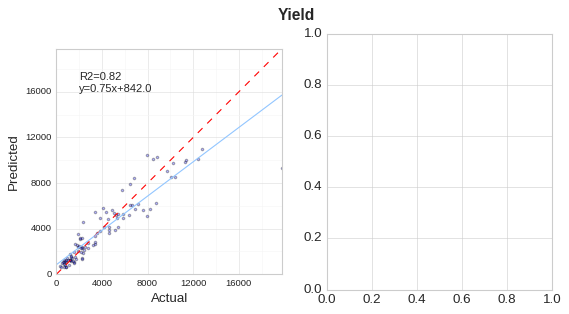

In [0]:
plt.style.use('seaborn-pastel')

fig, ax = plt.subplots(1,2, figsize=(8,4))

major_ticks = np.arange(0, max_axis, 4000)
minor_ticks = np.arange(0, max_axis, 2000)


ax[0].scatter(x=test_set_y_sample, y=test_x_predict, alpha=0.3, c='b', marker=".")
ax[0].set_xlim([0,max_axis])
ax[0].set_xticks(major_ticks)
ax[0].set_xticks(minor_ticks, minor=True)


ax[0].set_ylim([0,max_axis])
ax[0].set_yticks(major_ticks)
ax[0].set_yticks(minor_ticks, minor=True)

ax[0].grid(which='minor', color='whitesmoke')
ax[0].grid(which='major', color='gainsboro')
ax[0].set_axisbelow

ax[0].tick_params(labelsize=8.5)


ax[0].set_aspect('equal', 'box')

ax[0].plot(np.arange(0,max_axis,10),np.arange(0,max_axis,10),linewidth=1, linestyle='dashed', c='r') #1:1 line

#specify linear regression line (line through predictions vs truth)

x = np.arange(0,max_axis,10)
y = gradient*x + intercept
ax[0].plot(x,y,linewidth=1) 


ax[0].set(xlabel= 'Actual', ylabel = 'Predicted')
ax[0].text(x=2000, y=16000, s=f'R2={r2}\ny={gradient_round}x+{intercept_round}', ma = 'left', size=10)

plt.suptitle('Yield', fontsize=14, fontweight='bold')

plt.show()






In [0]:
#residuals

residual = test_x_predict-test_set_y_sample.to_numpy().reshape(1,-1)

max_residual = residual.max()
min_residual = residual.min()

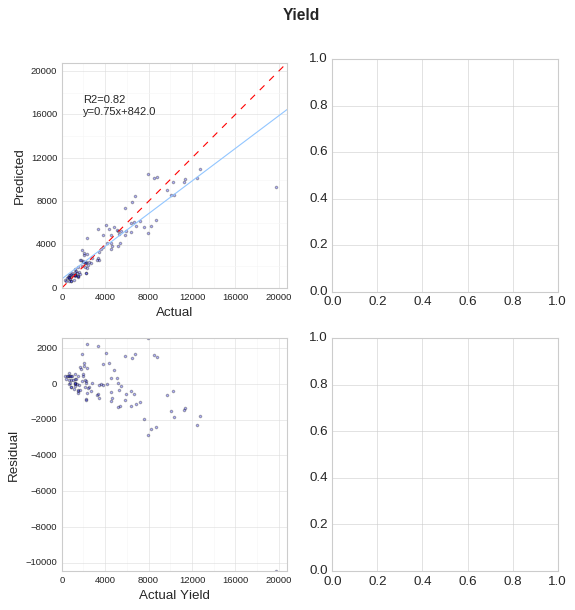

In [0]:
plt.style.use('seaborn-pastel')

fig, ax = plt.subplots(2,2, figsize=(8,8))

major_ticks = np.arange(0, max_axis, 4000)
minor_ticks = np.arange(0, max_axis, 2000)


ax[0,0].scatter(x=test_set_y_sample, y=test_x_predict, alpha=0.3, c='b', marker=".")
ax[0,0].set_xlim([0,max_axis])
ax[0,0].set_xticks(major_ticks)
ax[0,0].set_xticks(minor_ticks, minor=True)


ax[0,0].set_ylim([0,max_axis])
ax[0,0].set_yticks(major_ticks)
ax[0,0].set_yticks(minor_ticks, minor=True)

ax[0,0].grid(which='minor', color='whitesmoke')
ax[0,0].grid(which='major', color='gainsboro')
ax[0,0].set_axisbelow

ax[0,0].tick_params(labelsize=8.5)


ax[0,0].set_aspect('equal', 'box')

ax[0,0].plot(np.arange(0,max_axis,10),np.arange(0,max_axis,10),linewidth=1, linestyle='dashed', c='r') #1:1 line

#specify linear regression line (line through predictions vs truth)

x = np.arange(0,max_axis,10)
y = gradient*x + intercept
ax[0,0].plot(x,y,linewidth=1) 


ax[0,0].set(xlabel= 'Actual', ylabel = 'Predicted')
ax[0,0].text(x=2000, y=16000, s=f'R2={r2}\ny={gradient_round}x+{intercept_round}', ma = 'left', size=10)

####################################################################
##Plot for Residuals##

#major_ticks_2 = np.arange(0, max_axis, 4000)
#minor_ticks_2 = np.arange(0, max_axis, 2000)


ax[1,0].scatter(x=test_set_y_sample, y=residual, alpha=0.3, c='b', marker=".")
ax[1,0].set_xlim([0,max_axis])
ax[1,0].set_xticks(major_ticks)
ax[1,0].set_xticks(minor_ticks, minor=True)


ax[1,0].set_ylim([min_residual,max_residual])
#ax[1,0].set_yticks(major_ticks)
#ax[1,0].set_yticks(minor_ticks, minor=True)

ax[1,0].grid(which='minor', color='whitesmoke')
ax[1,0].grid(which='major', color='gainsboro')
ax[1,0].set_axisbelow

ax[1,0].tick_params(labelsize=8.5)


ax[1,0].set(xlabel= 'Actual Yield', ylabel = 'Residual')

plt.suptitle('Yield', fontsize=14, fontweight='bold')

plt.show()


#How to save models#

## sklearn stuff ##

In [0]:
# run a dummy model
train_set_x_sample = train_set_x_reduced_pd.sample(n=100, random_state=42)
train_set_y_sample = train_set_y.sample(n=100, random_state=42)
test_set_x_sample = test_set_x_reduced_pd.sample(n=100, random_state=42)
test_set_y_sample = test_set_y.sample(n=100, random_state=42)

from sklearn.ensemble import ExtraTreesRegressor

extra_trees = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=10)
extra_trees = extra_trees.fit(train_set_x_sample, train_set_y_sample)

extra_trees.score(test_set_x_sample,test_set_y_sample)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


0.8291296650591842

In [0]:
import joblib

In [0]:
joblib.dump(extra_trees, 'extra_trees_test.pkl')

['extra_trees_test.pkl']

In [0]:
model = joblib.load('extra_trees_test.pkl')

In [0]:
model.predict(test_set_x_sample)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


array([ 3374.63,  4283.42,   782.38,  7896.23,  5718.05,  5397.93,
        1016.44,  5259.22,  2679.11,   945.45,  1238.13,  9304.16,
        2862.22,  2620.7 ,  1292.96,  1038.32,  1302.21,   647.1 ,
        2803.32,  1193.97,  4137.71,  6297.94,  3975.29,  4365.15,
        3459.3 ,  5557.22,  1080.7 ,  6395.19,   665.75,  3210.03,
        9356.27,  6362.44,  6478.66,  5990.05,  1486.14,  4597.41,
        2028.09,  2236.77,  9817.07,   684.74,  1839.32,  2056.55,
         775.69,  1296.91,  3091.59,  9537.31,  1084.45,  4550.12,
         767.35,  1223.5 ,  4841.72,  8503.96,  1554.68,  5364.23,
        4104.62,  1225.38,  1954.3 ,  1228.37,  2674.91,  6083.8 ,
       11109.99,  6003.01,  4340.49,  9609.14,  2878.21,  1057.99,
        1287.13,  6359.15,  1879.11,  5042.12,  3847.57,  9305.2 ,
         828.39,  1186.15,  2913.78,  5314.59,  9320.2 ,  9941.81,
         964.55,  6559.19,  2866.  ,  9703.68,  5533.11,  2877.04,
        2469.43,  8969.96,  2611.86,  1600.82,   772.92, 11114

### xgboost ###

In [0]:
import xgboost as xgb

In [0]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

In [0]:
xgb_model.fit(train_set_x_sample, train_set_y_sample)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
joblib.dump(xgb_model, 'xgb_test.pkl')

['xgb_test.pkl']

In [0]:
model = joblib.load('xgb_test.pkl')

In [0]:
model.predict(test_set_x_sample)

array([ 2916.071  ,  4785.481  ,   781.84766,  8108.412  ,  5797.8613 ,
        5644.642  ,  1374.9579 ,  5103.5063 ,  2572.9634 ,  1652.803  ,
        1521.5322 ,  9203.719  ,  2750.3691 ,  2950.903  ,  1401.2427 ,
         632.09283,  1159.1826 ,   703.75604,  2117.4104 ,   940.5816 ,
        3603.631  ,  5930.0005 ,  4117.5796 ,  4703.8325 ,  3257.0186 ,
        5765.243  ,  1041.748  ,  5795.2925 ,   734.2943 ,  3658.1077 ,
        8800.001  ,  5999.551  ,  5673.2627 ,  5613.5566 ,  1402.8262 ,
        3974.388  ,  2518.8499 ,  2053.026  , 10799.958  ,   775.85504,
        1893.3688 ,  1953.3877 ,   898.353  ,  1466.0684 ,  3297.8215 ,
        9915.315  ,  1452.1033 ,  4287.9175 ,   777.97754,  1224.8973 ,
        4977.9697 ,  8516.485  ,  1471.8325 ,  5757.6475 ,  3183.8677 ,
        1510.2534 ,  2027.5914 ,  1220.2667 ,  2715.1716 ,  5605.4434 ,
       10683.647  ,  5598.6094 ,  4516.2046 , 10624.261  ,  2581.582  ,
         907.82886,  1289.6753 ,  5935.2466 ,  1491.9308 ,  4867

In [0]:
xgb_model.predict(test_set_x_sample)

array([ 2916.071  ,  4785.481  ,   781.84766,  8108.412  ,  5797.8613 ,
        5644.642  ,  1374.9579 ,  5103.5063 ,  2572.9634 ,  1652.803  ,
        1521.5322 ,  9203.719  ,  2750.3691 ,  2950.903  ,  1401.2427 ,
         632.09283,  1159.1826 ,   703.75604,  2117.4104 ,   940.5816 ,
        3603.631  ,  5930.0005 ,  4117.5796 ,  4703.8325 ,  3257.0186 ,
        5765.243  ,  1041.748  ,  5795.2925 ,   734.2943 ,  3658.1077 ,
        8800.001  ,  5999.551  ,  5673.2627 ,  5613.5566 ,  1402.8262 ,
        3974.388  ,  2518.8499 ,  2053.026  , 10799.958  ,   775.85504,
        1893.3688 ,  1953.3877 ,   898.353  ,  1466.0684 ,  3297.8215 ,
        9915.315  ,  1452.1033 ,  4287.9175 ,   777.97754,  1224.8973 ,
        4977.9697 ,  8516.485  ,  1471.8325 ,  5757.6475 ,  3183.8677 ,
        1510.2534 ,  2027.5914 ,  1220.2667 ,  2715.1716 ,  5605.4434 ,
       10683.647  ,  5598.6094 ,  4516.2046 , 10624.261  ,  2581.582  ,
         907.82886,  1289.6753 ,  5935.2466 ,  1491.9308 ,  4867